In [1]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=2465c18f7c7010e682153cb1c9e13838ffe030300a330ecd6654b1b3e69bf4ae
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 71.8 MB/s eta 0:00:00


#Description:
    -----------
    - The function first defines Pauli errors for one-qubit gates and two-qubit gates based on the input
      probabilities `alpha` and `beta`.
    - The one-qubit Pauli noise `error_1q` is a probabilistic combination of X, Y, and Z operators on
      single qubits, while the two-qubit Pauli noise `error_2q` applies X, Y, and Z operators on each qubit in
      a two-qubit gate.
    - These Pauli errors are then added to a NoiseModel instance (`noise_model`) that targets all qubits in the
      circuit and applies noise to the specified gate types.
    - A noisy simulator backend (`sim_noise`) is created using `AerSimulator`, loaded with the constructed noise model.
    - Finally, the circuit is transpiled for compatibility with the noisy backend using an optimization pass manager
      set to level 3 for efficient simulation.

In [16]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    pauli_error,
)

## add_pauli_noise:
Adds Pauli noise to a quantum circuit based on given probabilities for one-qubit and two-qubit gates. \\
This function applies random Pauli operators (X, Y, Z) to the qubits in the circuit after each one-qubit and two-qubit gate, using the probabilities `alpha` and `beta`, respectively.

    Parameters:
    ----------
    alpha : float
        Probability of applying a random Pauli operator (X, Y, Z) on a qubit after a one-qubit gate.
        Should be between 0 and 1, where 0 means no noise and 1 means always applying noise.
    
    beta : float
        Probability of applying a random Pauli operator (X, Y, Z) on both qubits after a two-qubit gate.
        Should be between 0 and 1, where 0 means no noise and 1 means always applying noise.
    
    circuit : QuantumCircuit
        The quantum circuit to which noise will be added. This circuit should be defined prior to
        calling this function and passed as an input.

    Returns:
    -------
    circ_tnoise : QuantumCircuit
        The transpiled circuit with noise applied, ready to be simulated on a noisy backend.

    sim_noise : AerSimulator
        A Qiskit Aer simulator backend configured with the noise model specified by `alpha` and `beta`.

    Notes:
    ------
    - This function supports only single- and two-qubit gate noise.
    - Ensure that the input probabilities `alpha` and `beta` are within the [0, 1] range.
    """

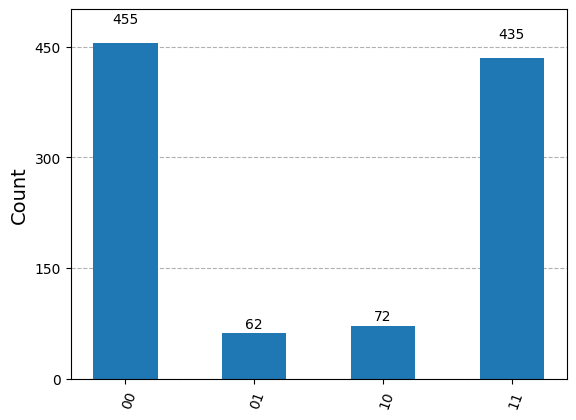

In [17]:

def add_pauli_noise(alpha, beta, circuit):
    """Add Pauli noise to a given circuit using probabilities alpha and beta."""
    noise_model = NoiseModel()

    # Define Pauli errors for one and two-qubit gates
    error_1q = pauli_error([('X', alpha/3), ('Y', alpha/3), ('Z', alpha/3), ('I', 1 - alpha)])
    error_2q = pauli_error([('X', beta/3), ('Y', beta/3), ('Z', beta/3), ('I', 1 - beta)]).tensor(pauli_error([('X', beta/3), ('Y', beta/3), ('Z', beta/3), ('I', 1 - beta)]))

    # Apply to all one-qubit and two-qubit gates
    noise_model.add_all_qubit_quantum_error(error_1q, ["u1", "u2", "u3","x","h","rx","ry","rz","p"])
    noise_model.add_all_qubit_quantum_error(error_2q, ["cx","cz","cry","crx","crz","cp","swap"])

    # Create noisy simulator backend
    sim_noise = AerSimulator(noise_model=noise_model)

    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
    circ_tnoise = passmanager.run(circuit)

    # Run and get counts
    result_bit_flip = sim_noise.run(circ_tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts(0)


    return circ_tnoise, sim_noise

# Example Usage
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
alpha = 0.05  # Noise probability after one-qubit gates
beta = 0.10   # Noise probability after two-qubit gates

noisy_circ, sim_noise = add_pauli_noise(alpha, beta, qc)

# Run the noisy simulation
result = sim_noise.run(noisy_circ).result()
counts = result.get_counts()

# Plot noisy result
from qiskit.visualization import plot_histogram
plot_histogram(counts)
